In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os
# for dirname, _, filenames in os.walk('/content/drive/MyDrive/minor_project/dataset/NITRDrone_Dataset'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [1]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.math import log , reduce_mean
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*10)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
!pip install patchify
from patchify import patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
root_directory = "/content/drive/MyDrive/minor_project/dataset/NITRDrone_Dataset/train/data"
patch_size = 512

In [5]:
scaler = MinMaxScaler()

In [6]:
# image = cv2.imread('/content/drive/MyDrive/minor_project/dataset/NITRDrone_Dataset/train/Tile 1/images/NITR_FR_1.png')

In [7]:
# print(image.shape)
# print(image.shape[0])
# print(image.shape[1])

In [8]:
# SIZE_X = (image.shape[0]//512)*512
# SIZE_Y = (image.shape[1]//512)*512
# image = Image.fromarray(image)
# image = image.crop((0,0,SIZE_X,SIZE_Y))
# print(SIZE_X)
# print(SIZE_Y)

In [9]:
# image

In [10]:
image_dataset = []
for path,subdirs,files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        images.sort()
        for i, image_name in enumerate(images):
            if image_name.endswith(".png"):
                
                image = cv2.imread(path+"/"+image_name,1)
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,SIZE_X,SIZE_Y))
                image = np.array(image)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):  
                        single_patch_img = patches_img[i,j,0,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        image_dataset.append(single_patch_img)


In [11]:
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        masks.sort()
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                
                mask = cv2.imread(path+'/'+mask_name, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):  
                        single_patch_mask = patches_mask[i,j,0,:,:]
                        mask_dataset.append(single_patch_mask)

In [12]:
image_dataset = np.array(image_dataset[:300])

In [13]:
image_dataset.shape

(300, 512, 512, 3)

In [14]:
# len(mask_dataset)

In [15]:
mask_dataset =  np.array(mask_dataset[:300])

In [16]:
mask_dataset.shape

(300, 512, 512, 3)

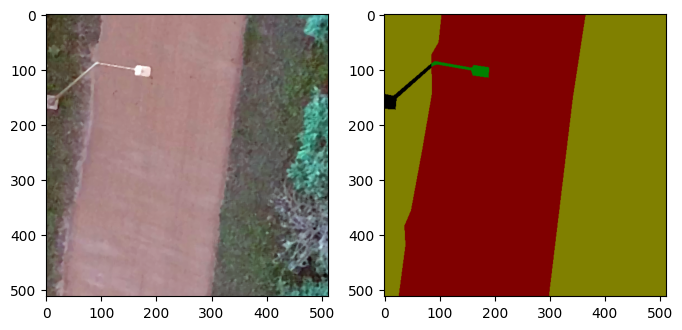

In [17]:
# 77 = random.randint(0,len(image_dataset))
# for 77 in range(56,80):
plt.figure(figsize=(8, 5))
plt.subplot(121)
plt.imshow(image_dataset[77])
plt.subplot(122)
plt.imshow(mask_dataset[77])
plt.show()

In [18]:
Background = '#000000'.lstrip('#')
Background = np.array(tuple(int(Background[i:i+2], 16) for i in (0, 2, 4)))

Occluded_road = '#008000'.lstrip('#')
Occluded_road = np.array(tuple(int(Occluded_road[i:i+2], 16) for i in (0, 2, 4)))

Road = '#800000'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4)))

Vegetation =  '#808000'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4)))

In [19]:
single_patch_mask.shape

(512, 512, 3)

In [20]:
# single_patch_img.shape

In [21]:
label = single_patch_mask

def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg [np.all(label == Background, axis = -1)] = 0
    label_seg [np.all(label == Occluded_road, axis = -1)] = 1
    label_seg [np.all(label == Road, axis = -1)] = 2
    label_seg [np.all(label == Vegetation, axis = -1)] = 3
    
    label_seg = label_seg[:,:,0]
    
    return label_seg

In [22]:
# rgb_to_2D_label(mask_dataset[0]).shape

In [23]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

In [24]:
# len(labels)

In [25]:
# labels

In [26]:
labels = np.array(labels)
labels.shape

(300, 512, 512)

In [27]:
labels_cat = to_categorical(labels)
labels_cat.shape

(300, 512, 512, 4)

In [28]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3]


In [29]:
# image_number = random.randint(0, len(image_dataset))

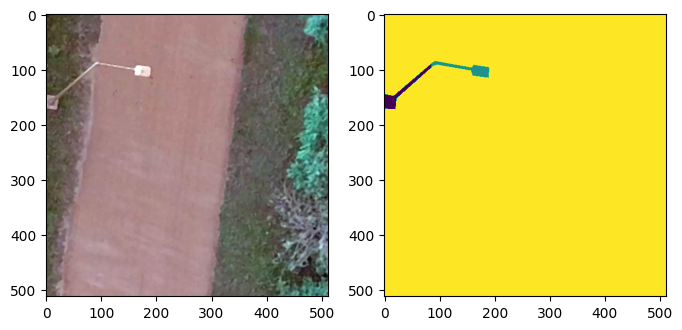

In [30]:
# 77 = random.randint(0,len(image_dataset))
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(image_dataset[77])
plt.subplot(122)
plt.imshow(labels[77], vmin=0, vmax=2)
plt.show()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, train_size = 0.8, test_size = 0.2, random_state = 42)

In [32]:
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

(240, 512, 512, 3)
(60, 512, 512, 3)
(240, 512, 512, 4)
(60, 512, 512, 4)


In [33]:
y_train.shape[-1] -1

3

In [34]:
del image_dataset, mask_dataset, labels_cat, labels

**U-Net Model**

In [35]:
def multi_unet_model(n_classes, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=3):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(512, (3, 3), activation='relu',  padding='same')(c5)
    
    #Expansive path 

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu',  padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu',  padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [36]:
n_classes =  y_train.shape[-1] -1 # without Unlabeled

In [37]:
n_classes

3

In [38]:
# n_classes = 4

**Model Summary**

In [ ]:
model = multi_unet_model(n_classes)
model.summary()

In [40]:
def categorical_crossentropy_with_mask(y_true, y_pred):
    y_true = y_true[:,:,:,1:]
    loss_matrix = y_true * -log(y_pred)
    loss = reduce_mean(loss_matrix, axis=(1,2,3)) + 0.001
    return loss
                   
def accuracy_with_mask(y_true, y_pred):
    # will be implemented
    
    y_true = y_true[:,:,:,1:]
    N = y_pred.size
    accuracy = np.sum(y_true == y_pred)/ N

    return 1

In [41]:
model.compile(optimizer='adam', loss=categorical_crossentropy_with_mask, metrics=['accuracy'])

In [88]:
# print(y_train.shape)
# print(X_train.shape)
# print(y_test.shape)
# print(X_test.shape)

(240, 512, 512, 4)
(240, 512, 512, 3)
(60, 512, 512, 4)
(60, 512, 512, 3)


**Model Training**

In [42]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 8, 
                    verbose=1,
                    epochs=10, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/10
30/30 [==============================] - 40s 520ms/step - loss: 0.1857 - accuracy: 0.0702 - val_loss: 0.1295 - val_accuracy: 0.0784
Epoch 2/10
30/30 [==============================] - 14s 455ms/step - loss: 0.0920 - accuracy: 0.0706 - val_loss: 0.1179 - val_accuracy: 0.0784
Epoch 3/10
30/30 [==============================] - 13s 443ms/step - loss: nan - accuracy: 0.0630 - val_loss: nan - val_accuracy: 0.0059
Epoch 4/10
30/30 [==============================] - 12s 401ms/step - loss: nan - accuracy: 0.0080 - val_loss: nan - val_accuracy: 0.0059
Epoch 5/10
30/30 [==============================] - 12s 406ms/step - loss: nan - accuracy: 0.0080 - val_loss: nan - val_accuracy: 0.0059
Epoch 6/10
30/30 [==============================] - 13s 426ms/step - loss: nan - accuracy: 0.0080 - val_loss: nan - val_accuracy: 0.0059
Epoch 7/10
30/30 [==============================] - 12s 409ms/step - loss: nan - accuracy: 0.0080 - val_loss: nan - val_accuracy: 0.0059
Epoch 8/10
30/30 [===========

**Predictions**

In [ ]:
vmin = 0
vmax = 2

for i in range(5):
    
    image_number = random.randint(0, X_test.shape[0])
    
    plt.figure(figsize=(24, 6))
    
    plt.subplot(141)
    plt.title('Image')
    plt.imshow(X_test[image_number])
    
    plt.subplot(142)
    plt.title('True')
    true = y_test[image_number].argmax(axis=2)
    plt.imshow(true, vmin = vmin, vmax = vmax)
    
    plt.subplot(143)
    plt.title('Prediction')
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2) + 1 # convert to 0-4 classes
    plt.imshow(prediction, vmin = vmin, vmax = vmax)
    
    plt.subplot(144)
    plt.title('Error')
    error = (true != prediction) & (true != 0)
    error = error.astype(int)
    plt.imshow(error, cmap='gray')
    
    plt.show()

In [43]:
root_directory = '/content/drive/MyDrive/minor_project/dataset/NITRDrone_Dataset/val'
validation_image = []
for path,subdirs,files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        images.sort()
        for i, image_name in enumerate(images):
            if image_name.endswith(".png"):
                
                image = cv2.imread(path+"/"+image_name,1)
                validation_image.append(image)

In [ ]:
for i in range(15,20):
  image = validation_image[i];
  plt.figure(figsize=(24, 6))
  plt.subplot(141)
  plt.title('Image')
  plt.imshow(image)

  plt.subplot(142)
  image3 = image.argmax(axis=2)
  plt.title('Prediction')
  plt.imshow(image3)
  plt.imshow(image3, vmin = 0, vmax = 2)
  
  plt.show()

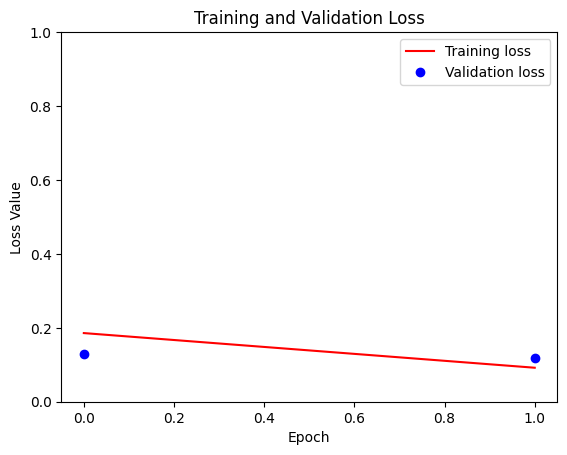

In [46]:
EPOCHS = 10
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/minor_project/dataset/NITRDrone_Dataset/uav.h5')